# Running in parallel with FOSI forcing

This is similar to the `matlab-comparison.ipynb` notebook, but provides an example of parallelizing the driver.
Parallelization is only necessary with large domains, so only the FOSI forcing sets are available.

## Running the model

Setup a `feisty` integration.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time

import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client
from dask_jobqueue import PBSCluster
from utils import compare_nc, default_config, old_settings
from xarray.tests import raise_if_dask_computes

import feisty

%matplotlib inline

/glade/work/mlevy/miniconda3/envs/dev-feisty2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Configure run

There are a few options on how to run:

1. `FOSI_spinup` cycles through the first year of 68 years of forcing generated from a CESM; its purpose is to provide equilibriated initial conditions
1. `FOSI_cesm` uses initial conditions from `FOSI_spinup` but the full 68 years of forcing from CESM to allow biomass to evolve

Note that both of these options run on the 85813 active ocean cells from the POP `gx1v7` grid.

In [3]:
# matlab_script = 'FOSI_spinup'
matlab_script = 'FOSI_cesm'

In [4]:
# Configuration settings for the offline driver as well as output generated in this notebook
driver_config = default_config()

# configurations that differ from default
driver_config['FOSI_cesm']['nyears'] = 5
driver_config['FOSI_spinup']['ignore_year_in_forcing'] = True
driver_config['FOSI_spinup']['nyears'] = 100
for matlab_script_loc in ['FOSI_cesm', 'FOSI_cesm_daily', 'FOSI_spinup']:
    driver_config[matlab_script_loc]['baseline'] = 'FOSI_cesm.nc'
    driver_config[matlab_script_loc]['baseline_compare'] = False
    driver_config[matlab_script_loc]['num_chunks'] = 9
    # driver_config[matlab_script_loc]['num_chunks'] = 6
    # driver_config[matlab_script]['max_output_time_dim'] = 146
    # driver_config[matlab_script]['max_output_time_dim'] = 250
    if matlab_script_loc != 'FOSI_spinup':
        driver_config[matlab_script_loc]['start_date'] = '0249-01-01'
        driver_config[matlab_script_loc]['make_err_plots'] = True
    driver_config[matlab_script_loc]['compare_forcing'] = False
    # diagnostic_names=driver_config[matlab_script_loc]['diagnostic_names'] = ['growth_rate']
    driver_config[matlab_script_loc]['plot_settings']['X'] = 55000  # looks good
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 15633  # large error in small classes
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 11677  # large error in medium classes
    # driver_config[matlab_script_loc]['plot_settings']['X'] = 76989  # large error in benthic

In [5]:
baselines_from_nc = xr.open_dataset(
    f'../matlab_baselines/{driver_config[matlab_script]["baseline"]}'
)

if matlab_script not in driver_config:
    raise ValueError(f"unknown matlab_script '{matlab_script}'")

feisty_driver = feisty.config_from_netcdf(
    './forcing.yaml',
    matlab_script,
    start_date=driver_config[matlab_script]['start_date'],
    ignore_year_in_forcing=driver_config[matlab_script]['ignore_year_in_forcing'],  # True,
    settings_in=driver_config[matlab_script]['settings_in'],
    diagnostic_names=driver_config[matlab_script]['diagnostic_names'],
    max_output_time_dim=driver_config[matlab_script]['max_output_time_dim'],
    num_chunks=driver_config[matlab_script_loc]['num_chunks'],
)

/glade/work/mlevy/codes/feisty/feisty/offline_driver.py:649: RuntimeWarning: deallocating CachingFileManager(<class 'netCDF4._netCDF4.Dataset'>, '/glade/work/mlevy/codes/feisty/input_files/feisty_input_from_FOSI_monthly.nc', mode='r', kwargs={'clobber': True, 'diskless': False, 'persist': False, 'format': 'NETCDF4'}), but file is not already closed. This may indicate a bug.
  domain_dict = _domain_from_netcdf(input_dict)
/glade/work/mlevy/codes/feisty/feisty/offline_driver.py:184: RuntimeWarning: deallocating CachingFileManager(<class 'netCDF4._netCDF4.Dataset'>, '/glade/work/mlevy/codes/feisty/input_files/FOSI_cesm_init_200yr.nc', mode='r', kwargs={'clobber': True, 'diskless': False, 'persist': False, 'format': 'NETCDF4'}), but file is not already closed. This may indicate a bug.
  self.obj = feisty_instance_type(


<!-- ## Run the model -->

First we spin up a dask cluster

In [6]:
if driver_config[matlab_script]['num_chunks'] > 1:
    dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})
    dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
    cluster = PBSCluster(
        cores=36,
        memory='300 GB',
        processes=np.minimum(driver_config[matlab_script]['num_chunks'], 9),
        queue='casper',
        walltime='1:00:00',
        resource_spec='select=1:ncpus=36:mem=300GB',
    )

    cluster.scale(1)
    client = Client(cluster)
else:
    client = None
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.22:46709,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Then we break up `feisty_driver` into a list of drivers all operating on distinct portions of the domain

In [7]:
%%time

nsteps = driver_config[matlab_script]['nyears'] * 365
# with raise_if_dask_computes():
feisty_driver.run_parallel(nsteps)
feisty_driver.gen_ds()

Starting run() at 13:43:31
Integrating 365 steps from 0249-01-01 00:00:00 (starting at 13:43:31)
[cftime.DatetimeNoLeap(249, 1, 16, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(249, 12, 31, 0, 0, 0, 0, has_year_zero=True)]
Integrating 365 steps from 0250-01-01 00:00:00 (starting at 13:44:04)
[cftime.DatetimeNoLeap(250, 1, 1, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(250, 12, 31, 0, 0, 0, 0, has_year_zero=True)]
Integrating 365 steps from 0251-01-01 00:00:00 (starting at 13:44:51)
[cftime.DatetimeNoLeap(251, 1, 1, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(251, 12, 31, 0, 0, 0, 0, has_year_zero=True)]
Integrating 365 steps from 0252-01-01 00:00:00 (starting at 13:45:56)
[cftime.DatetimeNoLeap(252, 1, 1, 0, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(252, 12, 31, 0, 0, 0, 0, has_year_zero=True)]
Integrating 365 steps from 0253-01-01 00:00:00 (starting at 13:47:17)
[cftime.DatetimeNoLeap(253, 1, 1, 0, 0, 0, 0, has_year_zero=True), cftime.Datetim

In [8]:
if 'new_restart_file' in driver_config[matlab_script]:
    feisty_driver.create_restart_file(driver_config[matlab_script]['new_restart_file'])

In [9]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(baselines_from_nc, feisty_driver.ds["biomass"], nsteps, thres=1e-15)

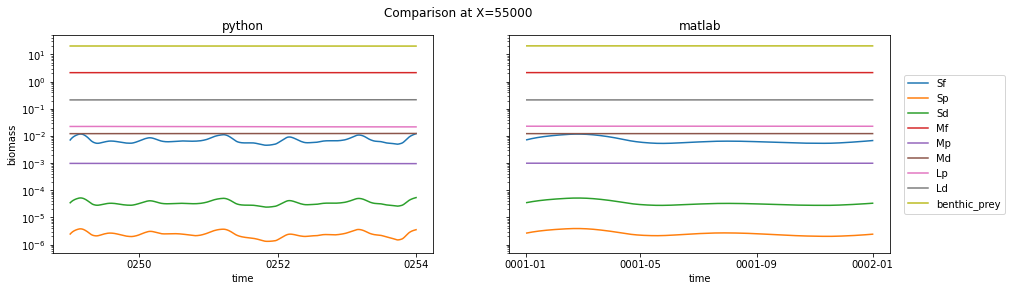

In [10]:
if driver_config[matlab_script]['make_plots']:
    if len(baselines_from_nc.time) > len(feisty_driver.ds.time):
        isel_dict = {"time": range(len(feisty_driver.ds.time))}
        baselines_tmp = baselines_from_nc.isel(isel_dict).assign_coords(
            {'group': feisty_driver.ds.group.data, 'time': feisty_driver.ds.time.data}
        )
    else:
        baselines_tmp = baselines_from_nc.assign_coords({'group': feisty_driver.ds.group.data})
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in feisty_driver.ds.group.data:
        feisty_driver.ds.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[0])
        baselines_tmp.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[1])
    for ax in axs:
        ax.set_ylim(driver_config[matlab_script]['plot_settings']['ylim'])
        ax.set_yscale("log")
    axs[0].set_title("python")
    axs[1].set_title("matlab")
    axs[1].set_ylabel("")
    axs[1].set_yticklabels("")
    plt.legend(feisty_driver.ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    fig.suptitle(f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}")

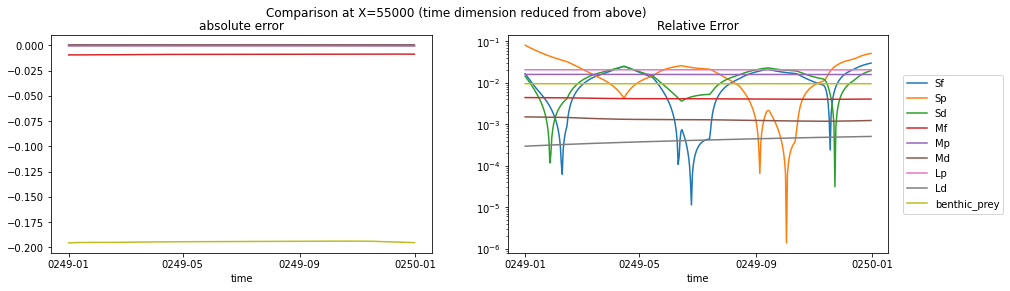

In [11]:
if driver_config[matlab_script]['make_err_plots']:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in feisty_driver.ds.group.data:
        da1 = feisty_driver.ds.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        )
        if len(baselines_from_nc.time) < len(feisty_driver.ds.time):
            da1 = da1.isel({"time": range(len(baselines_from_nc.time))})
        da2 = (
            baselines_tmp.biomass.sel(group=group)
            .isel(X=driver_config[matlab_script]['plot_settings']['X'])
            .assign_coords({'time': da1.time.data})
        )
        (da1 - da2).plot(ax=axs[0])
        (np.abs(da1 - da2) / da2).plot(ax=axs[1])
    axs[0].set_title("absolute error")
    axs[0].set_ylabel("")
    axs[1].set_title("relative error")
    axs[1].set_ylabel("")
    axs[1].set_yscale("log")
    plt.legend(feisty_driver.ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    plt.title("Relative Error")
    fig_suptitle = f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}"
    if len(baselines_from_nc.time) < len(feisty_driver.ds.time):
        fig_suptitle = f"{fig_suptitle} (time dimension reduced from above)"
    fig.suptitle(fig_suptitle)

In [12]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(
        baselines_from_nc.isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        feisty_driver.ds["biomass"].isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        nsteps,
        thres=1e-15,
    )